In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn import preprocessing
from theano import shared

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [3]:
import sys, IPython, scipy, matplotlib, pandas, seaborn, patsy, platform, theano, sklearn, statsmodels
print("""This notebook was created using:
Python {}
IPython {}
PyMC3 {}
ArviZ {}
NumPy {}
SciPy {}
Pandas {}
Seaborn {}
Patsy {}
Matplotlib {}
Theano {}
Sklearn {}
Statsmodels {}\n""".format(sys.version[:5], 
                             IPython.__version__, 
                             pm.__version__, 
                             az.__version__, 
                             np.__version__, 
                             scipy.__version__, 
                             pandas.__version__, 
                             seaborn.__version__, 
                             patsy.__version__, 
                             matplotlib.__version__, 
                             theano.__version__, 
                             sklearn.__version__, 
                             statsmodels.api.__version__))

This notebook was created using:
Python 3.7.4
IPython 7.13.0
PyMC3 3.8
ArviZ 0.8.2
NumPy 1.18.2
SciPy 1.4.1
Pandas 1.0.3
Seaborn 0.10.0
Patsy 0.5.1
Matplotlib 3.2.1
Theano 1.0.4
Sklearn 0.22.2.post1
Statsmodels 0.11.1



### 1. Consider the data (Wines2012) datatable.These data are expert ratings of 20 different French and American wines by 9 different French and American judges. Your goal is to model score, the subjective rating assigned by each judge to each wine. I recommend standardizing it.

### In this first problem, consider only variation among judges and wines. Construct index variables of judge and wine and then use these index variables to construct a linear regression model. Justify your priors. You should end up with 9 judge parameters and 20 wine parameters. Use ulam instead of quap to build this model, and be sure to check the chains for convergence. If you’d rather build the model directly in Stan or PyMC3, go ahead. I just want you to use Hamiltonian Monte Carlo instead of quadratic approximation.

### How do you interpret the variation among individual judges and indi- vidual wines? Do you notice any patterns, just by plotting the differences? Which judges gave the highest/lowest ratings? Which wines were rated worst/ best on average?


In [4]:
# load wine data
df = pd.read_csv("Data/Wines2012.csv", sep=";", header=0)

# standardized data
df['score_std'] = preprocessing.scale(df['score'])

# set index variable
df['wine_id'] = pd.Categorical(df['wine']).codes
df['judge_id'] = pd.Categorical(df['judge']).codes

df.head()

judge flight wine  score  wine.amer  judge.amer  score_std  \
0  Jean-M Cardebat  white   A1   10.0          1           0  -1.581002   
1  Jean-M Cardebat  white   B1   13.0          1           0  -0.451715   
2  Jean-M Cardebat  white   C1   14.0          0           0  -0.075286   
3  Jean-M Cardebat  white   D1   15.0          0           0   0.301143   
4  Jean-M Cardebat  white   E1    8.0          1           0  -2.333860   

   wine_id  judge_id  
0        0         3  
1        2         3  
2        4         3  
3        6         3  
4        8         3

In [5]:
# define model: score ~ judge + wine
with pm.Model() as m_wine_1:
    a = pm.Normal('a', mu=0, sd=0.5, shape=df['wine_id'].max()+1)
    b = pm.Normal('b', mu=0, sd=0.5, shape=df['judge_id'].max()+1)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a[df['wine_id'].values] + b[df['judge_id'].values])
    score = pm.Normal('score', mu=mu, sd=sigma, observed=df['score_std'])
    m_wine_1_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2462.99draws/s]


In [6]:
# show model summary
varnames = ['~mu']
az.summary(m_wine_1_trace, varnames, kind="stats",  round_to=2, hdi_prob=0.89)

mean    sd  hdi_5.5%  hdi_94.5%
a[0]   0.12  0.26     -0.30       0.53
a[1]   0.09  0.26     -0.33       0.51
a[2]   0.23  0.26     -0.19       0.64
a[3]   0.47  0.26      0.05       0.86
a[4]  -0.10  0.25     -0.52       0.29
a[5]  -0.31  0.26     -0.71       0.10
a[6]   0.24  0.26     -0.18       0.63
a[7]   0.23  0.26     -0.19       0.65
a[8]   0.07  0.26     -0.34       0.48
a[9]   0.10  0.26     -0.29       0.55
a[10] -0.01  0.27     -0.43       0.41
a[11] -0.02  0.26     -0.45       0.38
a[12] -0.09  0.25     -0.49       0.31
a[13]  0.01  0.25     -0.38       0.42
a[14] -0.18  0.26     -0.56       0.25
a[15] -0.16  0.27     -0.59       0.25
a[16] -0.12  0.25     -0.52       0.30
a[17] -0.72  0.25     -1.12      -0.33
a[18] -0.13  0.26     -0.56       0.26
a[19]  0.32  0.26     -0.11       0.73
b[0]  -0.28  0.20     -0.59       0.03
b[1]   0.21  0.19     -0.11       0.50
b[2]   0.20  0.19     -0.10       0.51
b[3]  -0.54  0.20     -0.85      -0.22
b[4]   0.80  0.19      0.49       1.10
b[5]   0.47  0.20      0.15       0.78
b[6]   0.13  0.20     -0.19       0.45
b[7]  -0.66  0.19     -0.95      -0.34
b[8]  -0.35  0.20     -0.67      -0.05
sigma  0.85  0.05      0.77       0.92

In [7]:
az.ess(m_wine_1_trace)

<xarray.Dataset>
Dimensions:   (a_dim_0: 20, b_dim_0: 9, mu_dim_0: 180)
Coordinates:
  * a_dim_0   (a_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * b_dim_0   (b_dim_0) int64 0 1 2 3 4 5 6 7 8
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
Data variables:
    a         (a_dim_0) float64 5.871e+03 6.275e+03 ... 5.759e+03 5.85e+03
    b         (b_dim_0) float64 4.5e+03 4.768e+03 ... 4.34e+03 4.302e+03
    sigma     float64 6.108e+03
    mu        (mu_dim_0) float64 9.546e+03 9.566e+03 ... 9.049e+03 9.284e+03

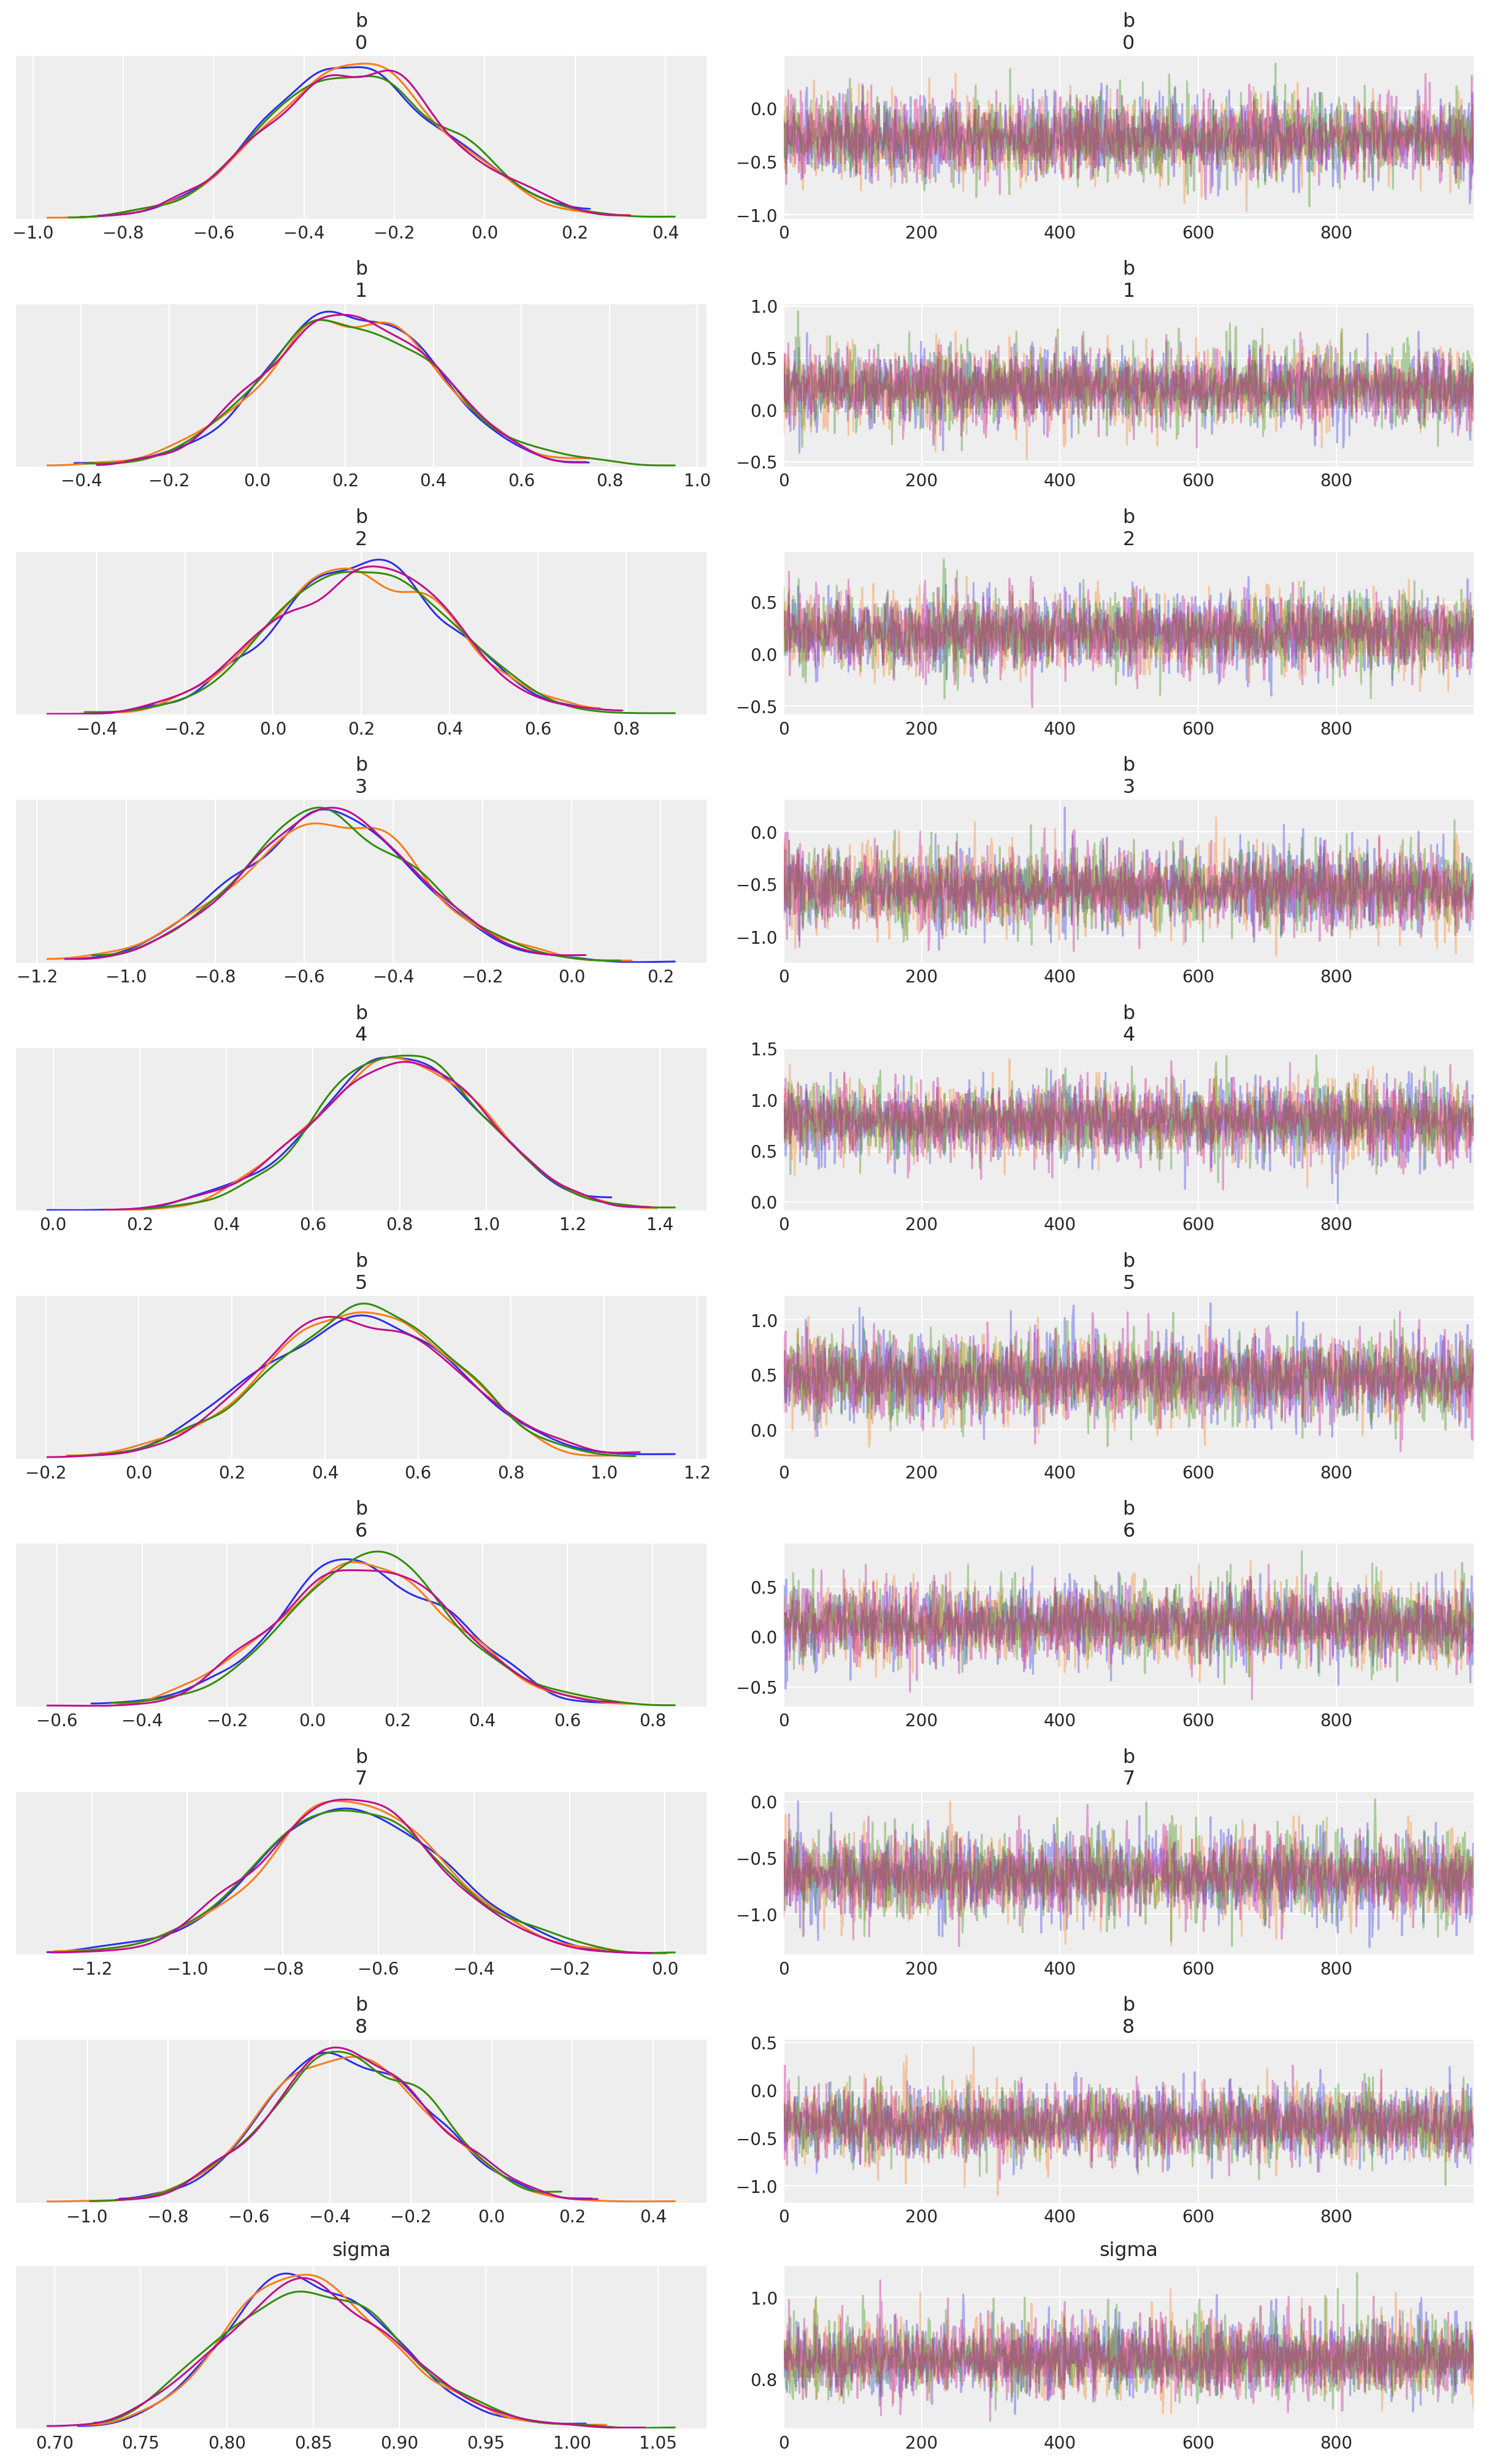

In [8]:
az.plot_trace(m_wine_1_trace, 
              var_names=(['b','sigma']))
plt.show()

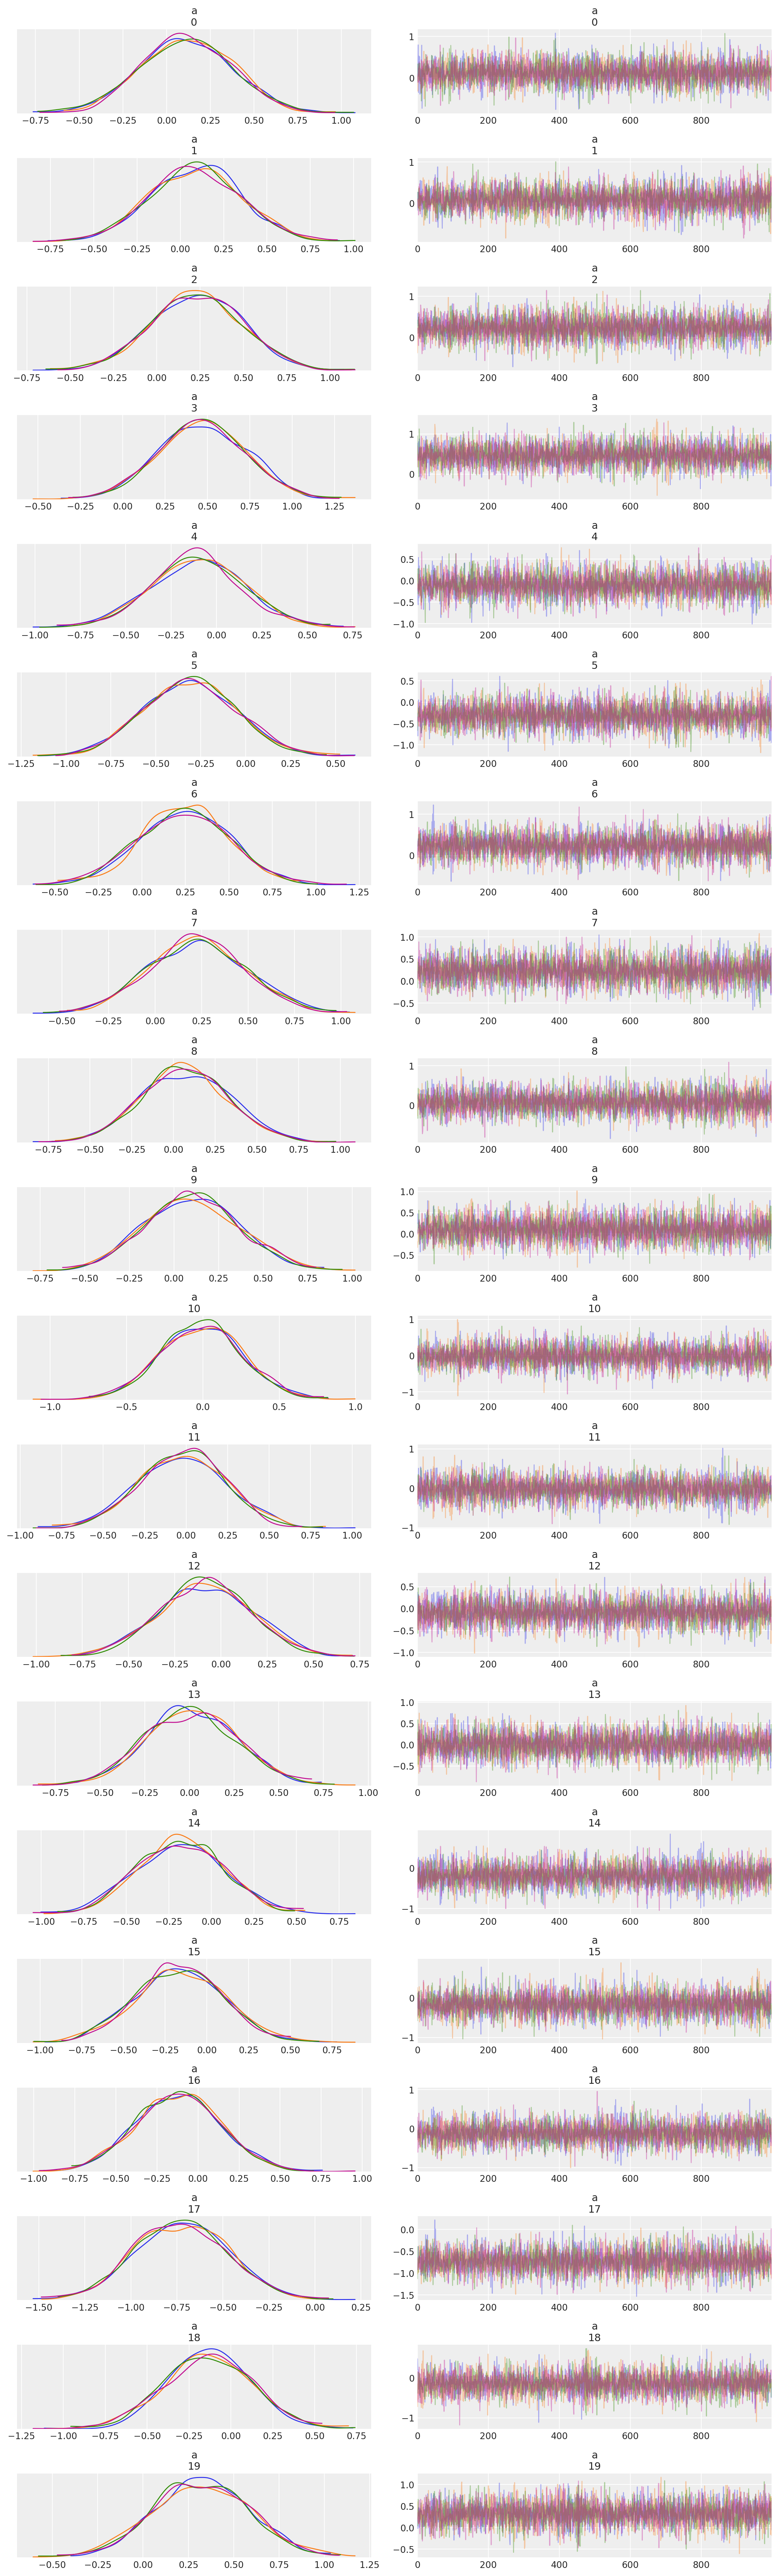

In [9]:
az.plot_trace(m_wine_1_trace, 
              var_names=(['a']))
plt.show()

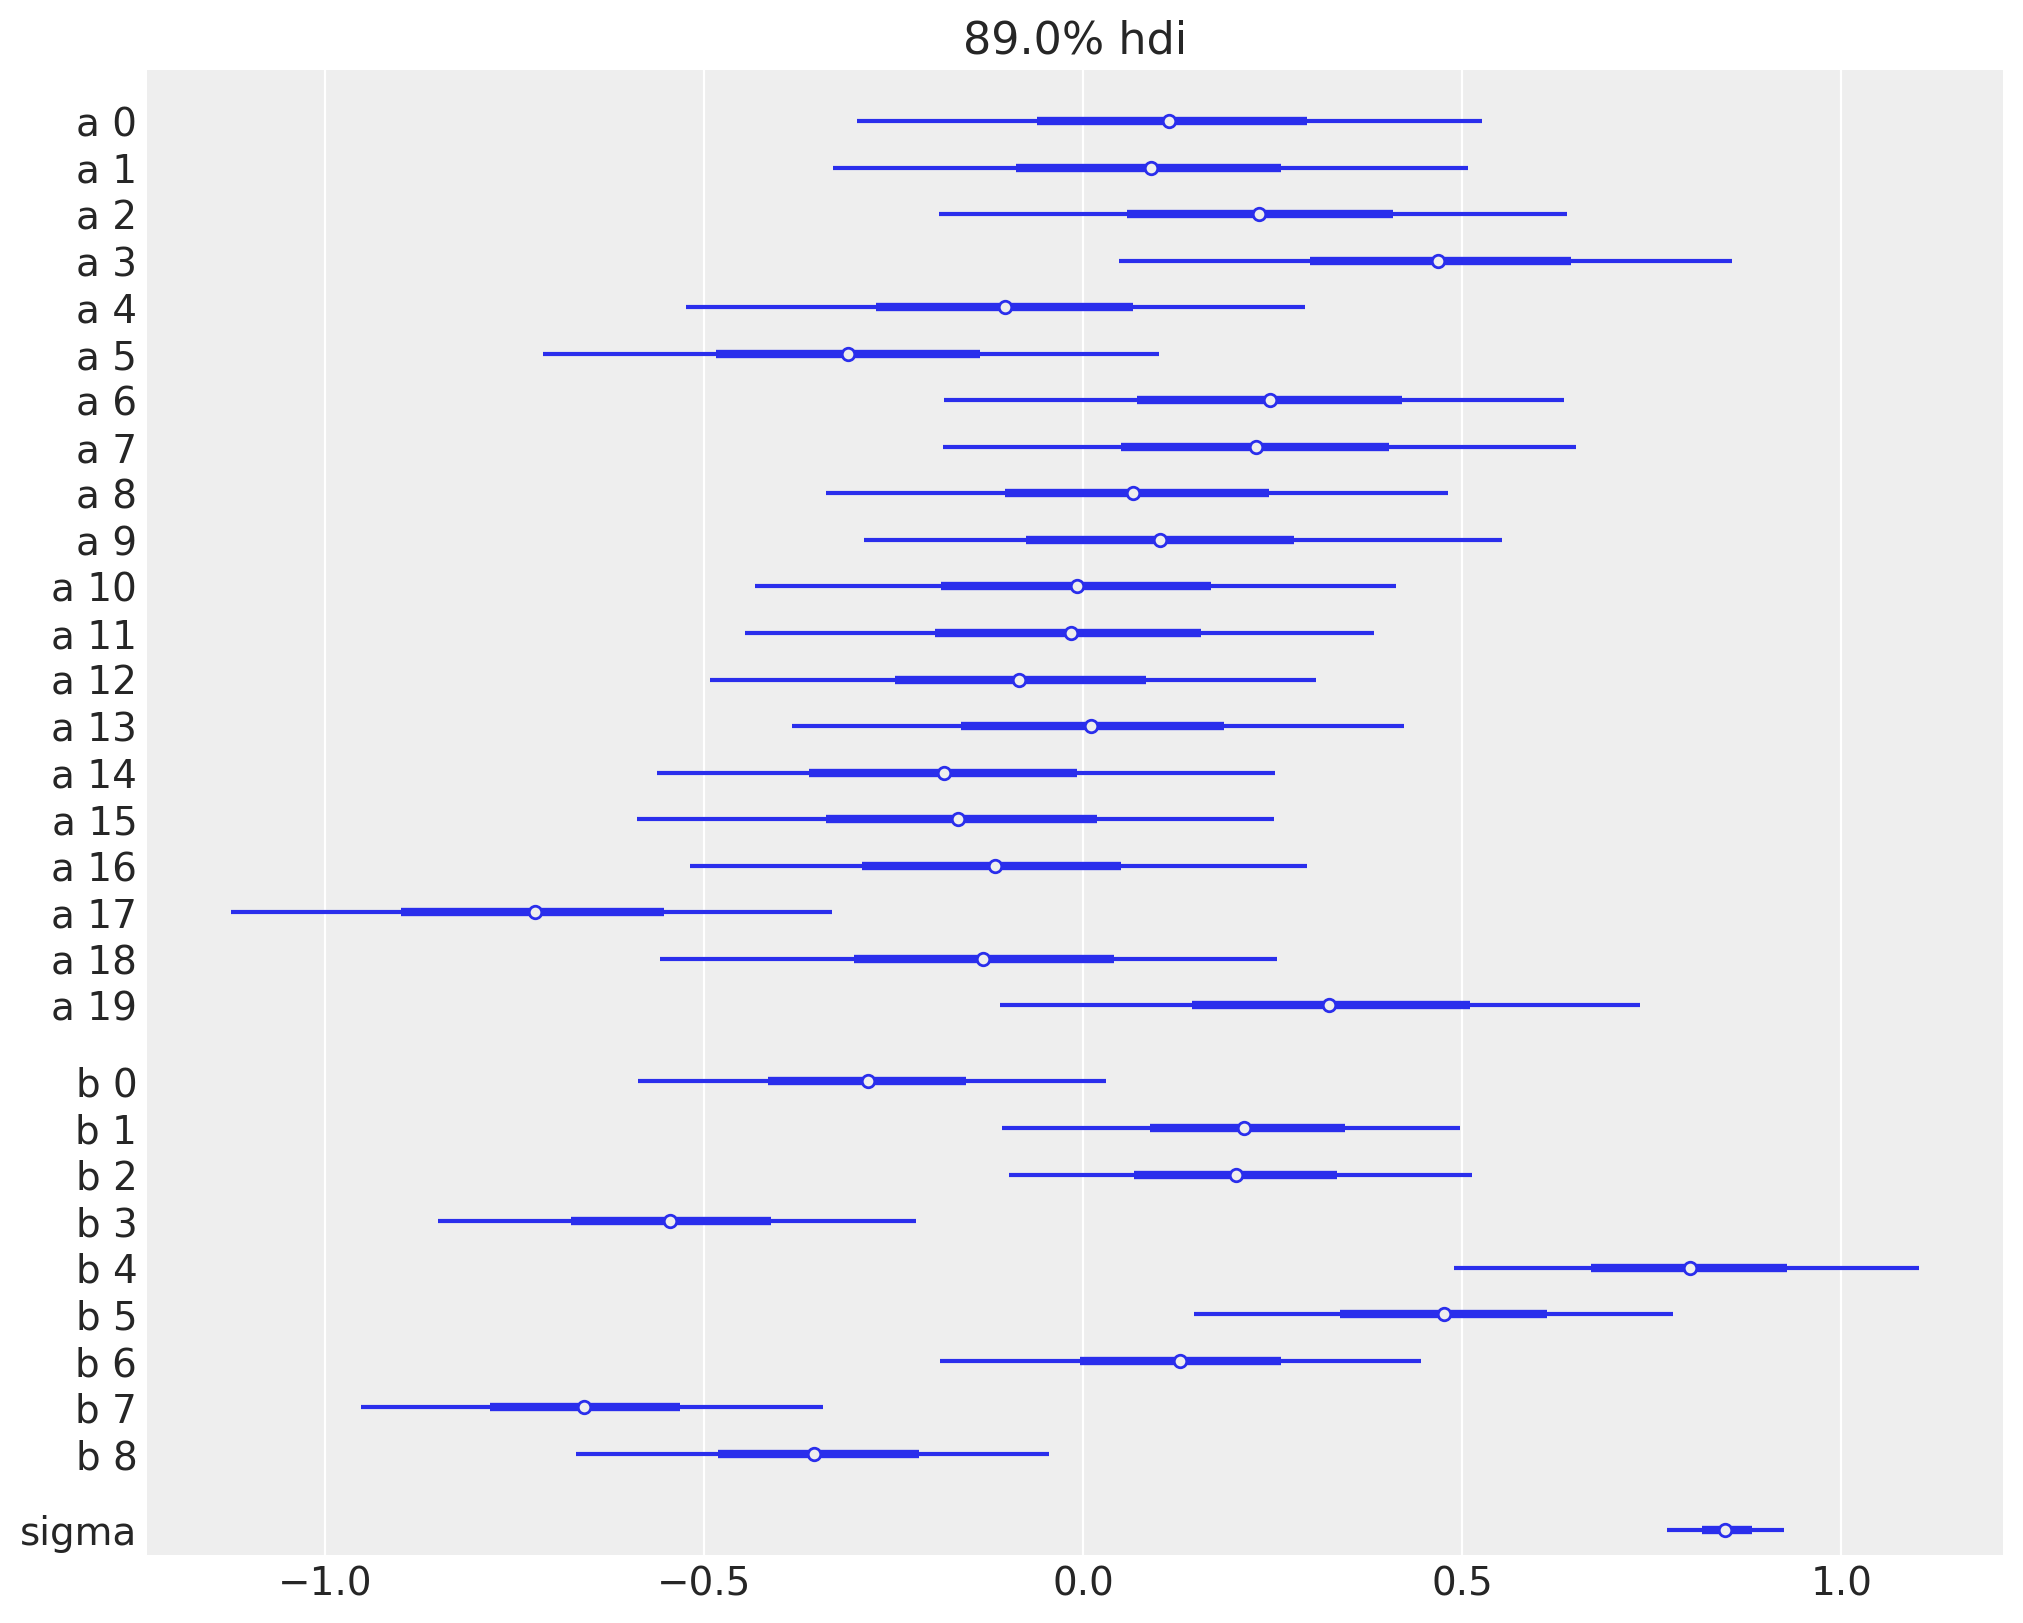

In [10]:
az.plot_forest(
    m_wine_1_trace,
    kind='forestplot',
    var_names=['a','b','sigma'],
    combined=True,
    ridgeplot_overlap=3,
    hdi_prob=0.89,
    figsize=(10, 8))
plt.show()

The $b$ parameters are the judges. Each represents an average deviation of the scores. So judges with lower values are harsher on average. Judges with higher values liked the wines more on average. There is some noticeable variation here. It is fairly easy to tell the judges apart.

The $a$ parameters are the wines. Each represents an average score across all judges. Except for wine 18, $a_{17}$, (a New Jersey red I think), there isn’t that much variation. These are good wines, after all. Overall, there is more variation from judge than from wine.

### 2. Now consider three features of the wines and judges:
 1. flight: Whether the wine is red or white.
 2. wine.amer: Indicator variable for American wines.
 3. judge.amer: Indicator variable for American judges.

### Use indicator or index variables to model the influence of these features on the scores. Omit the individual judge and wine index variables from Problem 1. Do not include interaction effects yet. Again use ulam, justify your priors, and be sure to check the chains. What do you conclude about the differences among the wines and judges? Try to relate the results to the inferences in Problem 1.

In [11]:
df['flight_id'] = pd.Categorical(df['flight']).codes
df.head()

judge flight wine  score  wine.amer  judge.amer  score_std  \
0  Jean-M Cardebat  white   A1   10.0          1           0  -1.581002   
1  Jean-M Cardebat  white   B1   13.0          1           0  -0.451715   
2  Jean-M Cardebat  white   C1   14.0          0           0  -0.075286   
3  Jean-M Cardebat  white   D1   15.0          0           0   0.301143   
4  Jean-M Cardebat  white   E1    8.0          1           0  -2.333860   

   wine_id  judge_id  flight_id  
0        0         3          1  
1        2         3          1  
2        4         3          1  
3        6         3          1  
4        8         3          1

In [12]:
# define model: score ~ flight + wine.amer + judge.amer
with pm.Model() as m_wine_2:
    a = pm.Normal('a', mu=0, sd=0.2)
    bW = pm.Normal('bW', mu=0, sd=0.5)
    bJ = pm.Normal('bJ', mu=0, sd=0.5)
    bR = pm.Normal('bR', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + bW*df['wine.amer'] + bJ*df['judge.amer'] + bR*df['flight_id'])
    score = pm.Normal('score', mu=mu, sd=sigma, observed=df['score_std'])
    m_wine_2_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bR, bJ, bW, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2666.11draws/s]


In [13]:
# show model summary
varnames = ['~mu']
az.summary(m_wine_2_trace, varnames, kind="stats",  round_to=2, hdi_prob=0.89)

mean    sd  hdi_5.5%  hdi_94.5%
a     -0.01  0.13     -0.23       0.17
bW    -0.18  0.14     -0.38       0.05
bJ     0.22  0.14      0.00       0.45
bR    -0.00  0.14     -0.23       0.22
sigma  1.00  0.05      0.92       1.08

As expected, red and wines are on average the same --- $bR$ is right on top of zero. American judges seem to be more on average slightly more generous with ratings --- $bJ$ is slightly but reliably above zero. American wines have slightly lower average ratings than French wines --- $bW$ is mostly below zero, but not very large in absolute size.

Okay, now for an index variable version. The thing about index variables is that you can easily end up with more parameters than in an equivalent indicator variable model. But it’s still the same posterior distribution. You can convert from one to the other (if the priors are also equivalent). We’ll need three index variables:

In [14]:
# define model: score ~ judge + wine + flight
with pm.Model() as m_wine_3:
    w = pm.Normal('w', mu=0, sd=0.5, shape=df['wine.amer'].max()+1)
    j = pm.Normal('j', mu=0, sd=0.5, shape=df['judge.amer'].max()+1)
    f = pm.Normal('f', mu=0, sd=0.5, shape=df['flight_id'].max()+1)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', w[df['wine.amer'].values] + j[df['judge.amer'].values] + f[df['flight_id'].values])
    score = pm.Normal('score', mu=mu, sd=sigma, observed=df['score_std'])
    m_wine_3_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, f, j, w]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:05<00:00, 1378.63draws/s]


In [15]:
# show model summary
varnames = ['~mu']
az.summary(m_wine_3_trace, varnames, kind="stats",  round_to=2, hdi_prob=0.89)

mean    sd  hdi_5.5%  hdi_94.5%
w[0]   0.10  0.30     -0.37       0.59
w[1]  -0.08  0.30     -0.57       0.39
j[0]  -0.12  0.30     -0.57       0.38
j[1]   0.12  0.29     -0.37       0.56
f[0]  -0.01  0.31     -0.49       0.47
f[1]   0.00  0.31     -0.53       0.46
sigma  1.00  0.06      0.92       1.09

To see that this model is the same as the previous, let’s compute contrasts. The contrast between American and French wines is:

In [16]:
az.summary(m_wine_3_trace['w'][:,1] - m_wine_3_trace['w'][:,0], kind="stats",  round_to=2, hdi_prob=0.89)

mean    sd  hdi_5.5%  hdi_94.5%
x -0.18  0.15     -0.43       0.04

That’s almost exactly the same mean and standard deviation as $bW$ in the first model. The other contrasts match as well.

### 3. Now consider two-way interactions among the three features. You should end up with three different interaction terms in your model. These will be easier to build, if you use indicator variables. Again use ulam, justify your priors, and be sure to check the chains. Explain what each interaction means. Be sure to interpret the model’s predictions on the outcome scale (mu, the expected score), not on the scale of individual parameters. You can use link to help with this, or just use your knowledge of the linear model instead.

### What do you conclude about the features and the scores? Can you relate the results of your model(s) to the individual judge and wine inferences from Problem 1?

In [17]:
# define model: score ~ flight + wine.amer + judge.amer with interactions
with pm.Model() as m_wine_4:
    a = pm.Normal('a', mu=0, sd=0.2)
    bW = pm.Normal('bW', mu=0, sd=0.5)
    bJ = pm.Normal('bJ', mu=0, sd=0.5)
    bR = pm.Normal('bR', mu=0, sd=0.5)
    bWJ = pm.Normal('bWJ', mu=0, sd=0.25)
    bJR = pm.Normal('bJR', mu=0, sd=0.25)
    bWR = pm.Normal('bWR', mu=0, sd=0.25)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a 
                          + bW*df['wine.amer'] 
                          + bJ*df['judge.amer'] 
                          + bR*(1-df['flight_id'])
                          + bWJ*df['wine.amer']*df['judge.amer']
                          + bJR*df['judge.amer']*(1-df['flight_id'])
                          + bWR*df['wine.amer']*(1-df['flight_id']))
    score = pm.Normal('score', mu=mu, sd=sigma, observed=df['score_std'])
    m_wine_4_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bWR, bJR, bWJ, bR, bJ, bW, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:05<00:00, 1568.10draws/s]


In [18]:
# show model summary
varnames = ['~mu']
az.summary(m_wine_4_trace, varnames, kind="stats",  round_to=2, hdi_prob=0.89)

mean    sd  hdi_5.5%  hdi_94.5%
a     -0.04  0.13     -0.27       0.15
bW    -0.08  0.17     -0.34       0.21
bJ     0.21  0.18     -0.06       0.51
bR     0.08  0.19     -0.24       0.36
bWJ   -0.02  0.18     -0.30       0.29
bJR    0.05  0.18     -0.26       0.31
bWR   -0.22  0.18     -0.53       0.06
sigma  1.00  0.05      0.91       1.08

But right away you might notice that $bW$ is now close to zero and overlaps it a lot on both sides. NJ wines are no longer on average worse. So the interactions did something. Glancing at the interaction parameters, you can see that only one of them has much mass away from zero, $bWR$, the interaction between NJ wines and red flight, so red NJ wines. To get the predicted scores for red and white wines from both NJ and France, for both types of judges.

In [19]:
# define model: score ~ flight + wine.amer + judge.amer with interactions
with pm.Model() as m_wine_5:
    w = pm.Normal('w', mu=0, sd=0.5, shape=df['wine.amer'].max()+1)
    j = pm.Normal('j', mu=0, sd=0.5, shape=df['judge.amer'].max()+1)
    f = pm.Normal('f', mu=0, sd=0.5, shape=df['flight_id'].max()+1)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', w[df['wine.amer'].values] 
                          + j[df['judge.amer'].values] 
                          + f[df['flight_id'].values]
                          + w[df['wine.amer'].values]*j[df['judge.amer'].values]
                          + w[df['wine.amer'].values]*f[df['flight_id'].values]
                          + j[df['judge.amer'].values]*f[df['flight_id'].values])
    score = pm.Normal('score', mu=mu, sd=sigma, observed=df['score_std'])
    m_wine_5_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, f, j, w]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:06<00:00, 1240.75draws/s]


In [20]:
# show model summary
varnames = ['~mu']
az.summary(m_wine_5_trace, varnames, kind="stats",  round_to=2, hdi_prob=0.89)

mean    sd  hdi_5.5%  hdi_94.5%
w[0]   0.13  0.31     -0.40       0.56
w[1]  -0.06  0.26     -0.47       0.35
j[0]  -0.11  0.26     -0.55       0.26
j[1]   0.13  0.31     -0.39       0.59
f[0]   0.06  0.28     -0.41       0.48
f[1]   0.03  0.27     -0.42       0.45
sigma  1.00  0.05      0.92       1.09

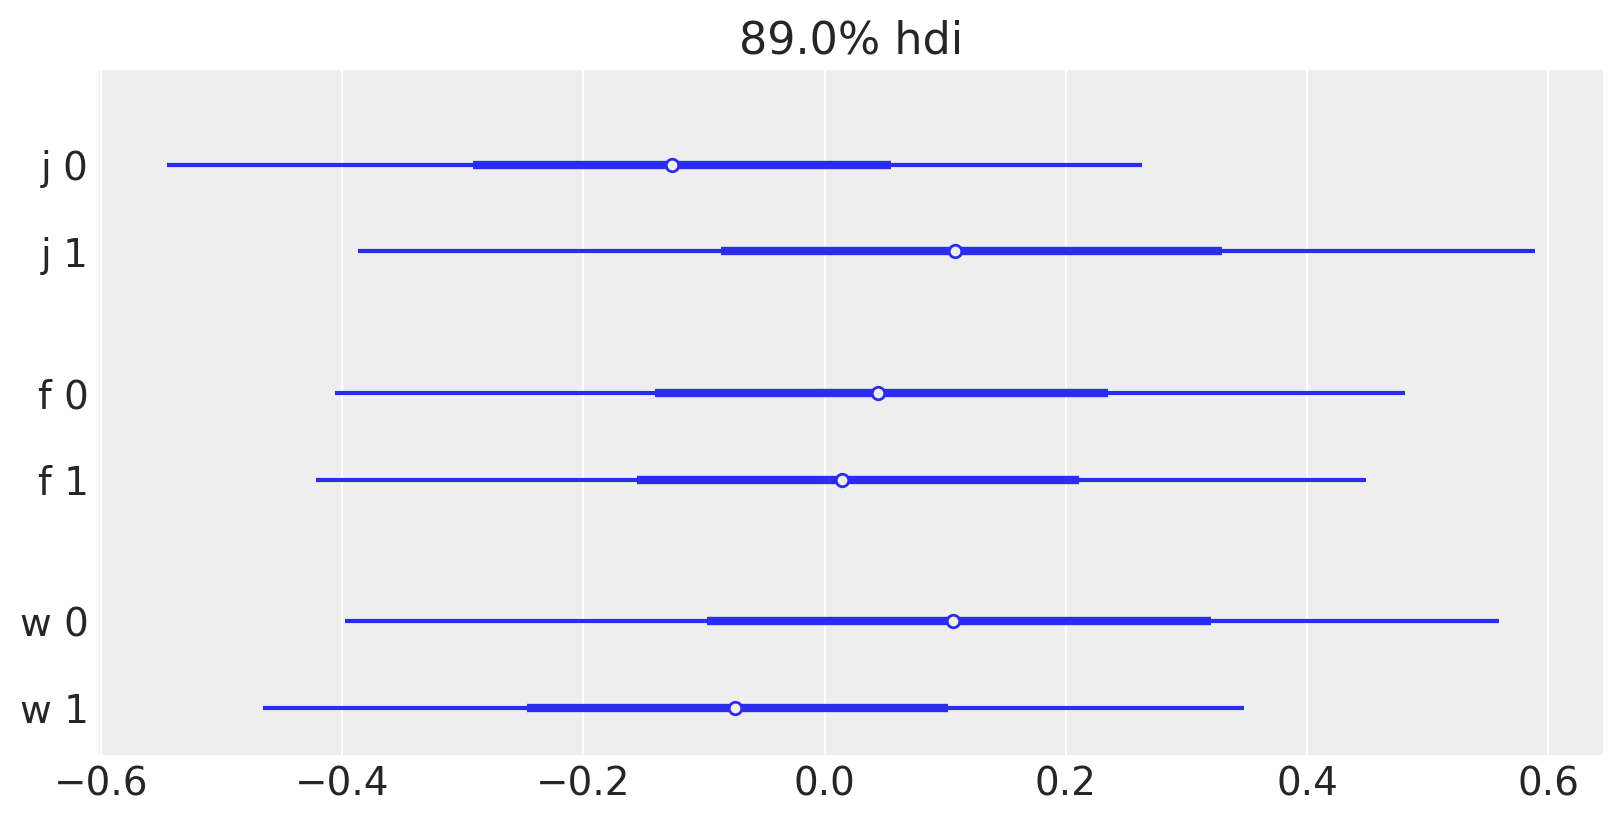

In [21]:
az.plot_forest(
    m_wine_5_trace,
    kind='forestplot',
    var_names=['j','f','w'],
    combined=True,
    ridgeplot_overlap=3,
    hdi_prob=0.89,
    figsize=(8, 4))
plt.show()

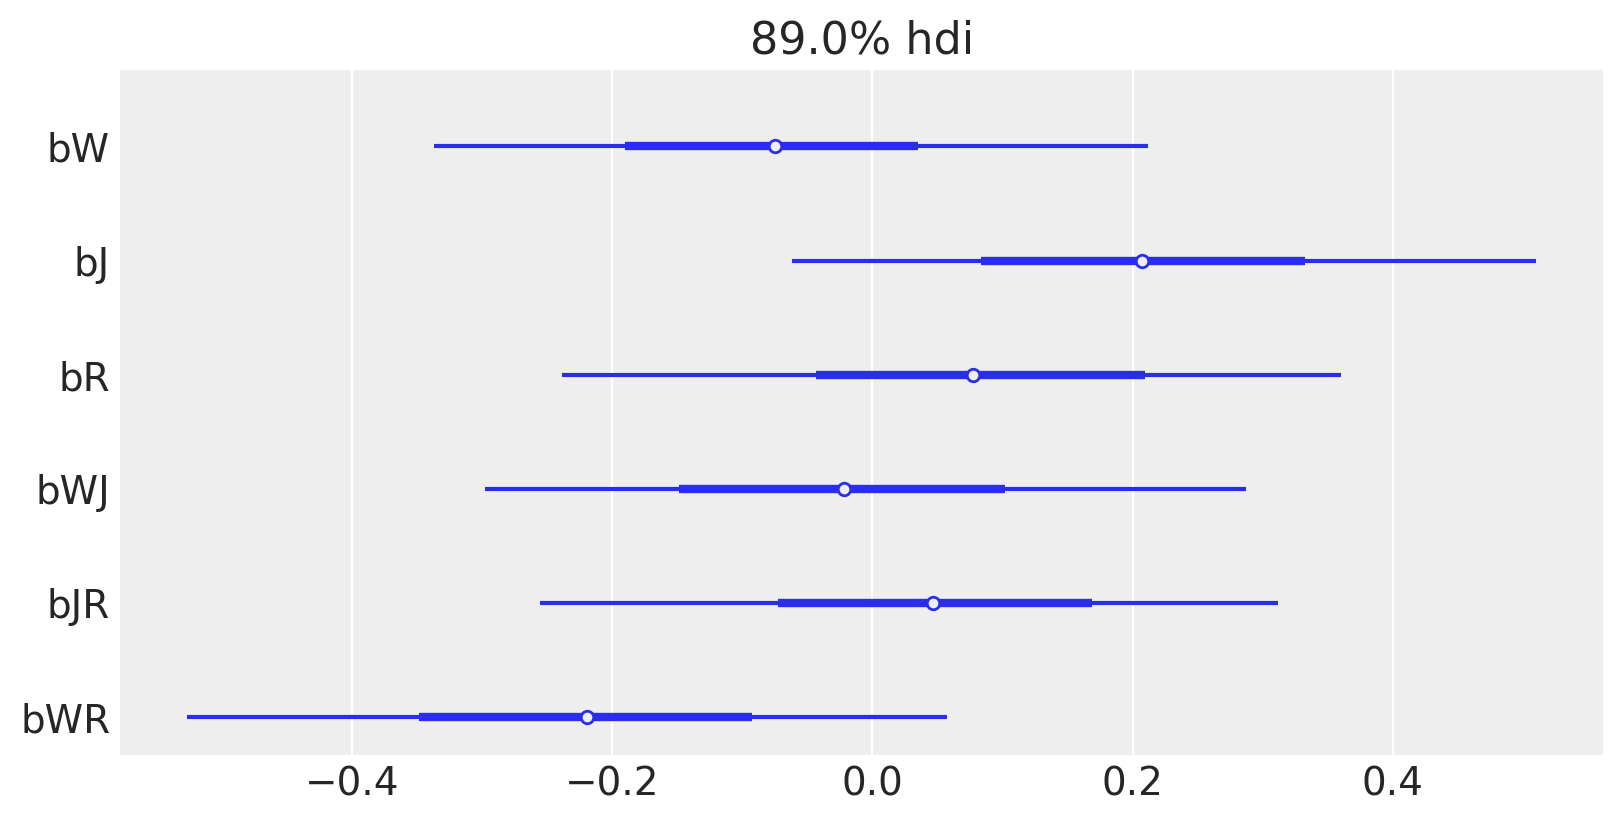

In [22]:
az.plot_forest(
    m_wine_4_trace,
    kind='forestplot',
    var_names=['bW','bJ','bR','bWJ','bJR','bWR'],
    combined=True,
    ridgeplot_overlap=3,
    hdi_prob=0.89,
    figsize=(8, 4))
plt.show()